In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import time
import ZeroLevel_Qontrol as q0
import FirstLevel_Qontrol as q1
import SecondLevel_Qontrol as q2
from powermeter import Powermeter as PM
import heater_dict as hd
import heater_characterisation_funcs as hcf
from tunicsqontrol import tunics
from scipy import optimize

pi=np.pi

In [3]:
# powermeter1 = Powermeter('PM100USB', serial='P2003916', unit='dBm', wavelength=1550) 
unit='dBm'
wavelength=1550
#Alice (tele) powermeters 10/03/20:
PMa = PM('PM100USB', serial='P2008115')
PMb = PM('PM100USB', serial='P2010371') 
PMc = PM('PM100USB', serial='P2003683') 
PMd = PM('PM100USB', serial='P2007347')
#Charlie powermeters 10/03/20:
PMe = PM('PM100USB', serial='P2005653')
PMf = PM('PM100USB', serial='P2010372') 
PMg = PM('PM100USB', serial='P2008116') 
PMh = PM('PM100USB', serial='P2007346')

In [4]:
#laser initialisation and wavelengths
serial_port_name = 'COM11'
mytunics = tunics(serial_port_name = serial_port_name)
                  
p_wavelength = 1549.3
i_wavelength = 1558.98
s_wavelength = 1539.77


Connected to Tunics laser on serial port COM11



In [5]:
h=q2.heater_class(hd.board_list,hd.heaters)

In [11]:
#to mode 1 + 4
h.set_many_phases({'BS1':pi/2+0.25, 'BS2':0, 'BS3':0, 'WDM1':pi, 'WDM2':0, 'WDM4':pi, 'WDM3':0, 'Prj_RY1':pi+0.23, 'Prj_RY4':pi-0.02, 'Ctr_1':pi, 'Ctr_2':pi, 'Attb1':pi/2-0.25, 'Attb2':pi, 'Attb3':pi, 'Attb4':pi, 'MZIb1':pi, 'MZIb2':0, 'MZIb3':pi/2, 'MZIb4':pi, 'Phb1':0})

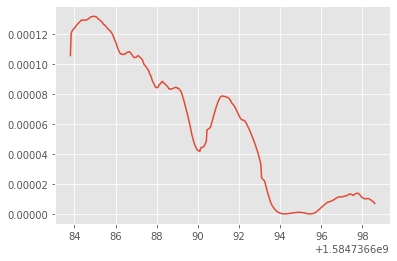

In [13]:
plt.plot(np.array(power_over_time).T[0], np.array(power_over_time).T[1])

In [51]:
saving_array=(list(np.array(power_over_time).T[0]),list(np.array(power_over_time).T[1]))
np.savetxt(f'C:/Users/IT072488-admin/University of Bristol/grp-Multi 3 Chip Project - Multi_3_Chips/pycode_molly/Experimental code/Experimental data/time_to_set_Prj_RY4.csv', saving_array, delimiter=',', header='#time,powers')

In [ ]:
print((list(np.array(power_over_time).T[0]),list(np.array(power_over_time).T[1])))

In [31]:
h.set_many_phases({'BS1':pi, 'BS2':0, 'WDM1':pi, 'WDM2':0, 'Prj_RY1':pi/2+0.23})

In [32]:
print(PMd.measure(),PMa.measure())

-13.868963851301281 -13.807274012192114


In [62]:
h.set_many_phases({'BS1':pi/2+0.25, 'BS3':0, 'WDM4':pi, 'WDM3':0, 'Prj_RY4':pi/2-0.02, 'Ctr_1':pi, 'Ctr_2':pi})

In [63]:
print(PMd.measure(),PMa.measure())

-17.8377532805075 -17.85343201019989


To balance powers on Alice 'BS1' : pi/2 + 0.25, 'Prj_RY4' : pi/2 - 0.02, 'Prj_RY1' : pi/2+0.23

In [43]:
h.set_many_phases({'BS1':pi/2+0.25, 'BS2':0, 'BS3':0, 'WDM1':pi, 'WDM2':0, 'WDM4':pi, 'WDM3':0, 'Prj_RY1':pi/2+0.23, 'Prj_RY4':pi/2-0.02, 'Ctr_1':pi, 'Ctr_2':pi, 'Attb1':pi/2-0.25, 'Attb2':pi, 'Attb3':pi, 'Attb4':pi, 'MZIb1':pi, 'MZIb2':pi, 'MZIb3':pi, 'MZIb4':pi})

In [82]:
h.set_many_phases({'Attb1':pi, 'Attb2':pi, 'Attb3':pi/2, 'Attb4':pi, 'MZIb1':pi, 'MZIb2':pi, 'MZIb3':pi, 'MZIb4':pi})

In [83]:
print(PMe.measure(),PMf.measure(),PMg.measure(),PMh.measure())

2.57838373e-08 2.5852307e-08 4.33850378e-09 -3.50953034e-12


## Two mode phase stabilisation

In [6]:
mytunics.laser_switch('on')
mytunics.laser_wavelength(s_wavelength)
mytunics.laser_power(0)

In [23]:
def SineSq(x,amp,freq,x_off,y_off):
    return amp*np.sin(freq*x+x_off)**2+y_off

def FringeFit():
    phase=[]
    powersE=[]
    powersF=[]
    x=np.linspace(0, 2*pi, 30)
    for i in range(0,10):#taking 10 points but will fit to 5 (for testing to compare wider range of real points to the fitted smaller samples)
        h.set_phase('Phb1', pi/4*i)
        time.sleep(0.2)
        powersE.append(PMe.measure())
        #powersF.append(PMf.measure())
        phase.append(pi/4*i)
    
    sampling_powers=powersE[0:5]
    
    initial_guess=[(max(sampling_powers)-min(sampling_powers)), 0.5, 0, min(sampling_powers)]
    param_bounds=([0, 0, -pi, 0], [2*max(sampling_powers), 1, pi, max(sampling_powers)])
    
    paramsE, pcovE = optimize.curve_fit(SineSq, phase[0:5], sampling_powers, bounds=param_bounds, p0=initial_guess)#bounds=param_bounds , p0=initial_guess
    #paramsF, pcovF = optimize.curve_fit(SineSq, phase, powersF, p0=initial_guess)
    plt.scatter(phase[0:5], powersE[0:5])
    plt.scatter(phase[5:10], powersE[5:10])
    plt.plot(x, SineSq(x, paramsE[0], paramsE[1], paramsE[2], paramsE[3]))
    #plt.plot(x, SineSq(x, paramsF[0], paramsF[1], paramsF[2], paramsF[3]))
    plt.ylim(0,2*max(sampling_powers))
    plt.show()
    print(paramsE)
    print(initial_guess)
    #print(paramsF)
    return initial_guess, phase, powersE, paramsE

### Modes 1 + 4

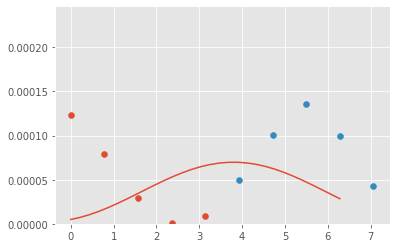

[6.73139595e-05 3.63140129e-01 1.89900919e-01 2.51126283e-06]


In [24]:
h.set_many_phases({'BS1':pi/2+0.25, 'BS2':0, 'BS3':0, 'WDM1':pi, 'WDM2':0, 'WDM4':pi, 'WDM3':0, 'Prj_RY1':pi+0.23, 'Prj_RY4':pi-0.02, 'Ctr_1':pi, 'Ctr_2':pi, 'Attb1':pi/2-0.25, 'Attb2':pi, 'Attb3':pi, 'Attb4':pi, 'MZIb1':pi, 'MZIb2':0, 'MZIb3':pi/2, 'MZIb4':pi, 'Phb1':0})
time.sleep(0.2)

#DOESN'T FIT SENSIBLY WITH BOUNDS AND PARAMS BUT NEED BOUNDS SO IS POSITIVE

initial_guess, phase, powersE, paramsE=FringeFit()

In [18]:
print (max(powersE)-min(powersE))

0.00016149948032999998


In [46]:
print(list(powersE)[3:5])

[1.8457065199999997e-05, 4.6466053199999995e-06]


## Modes 1+2

In [ ]:
h.set_many_phases({'BS1':pi/2+0.25, 'BS2':0, 'BS3':0, 'WDM1':pi, 'WDM2':0, 'WDM4':pi, 'WDM3':0, 'Prj_RY1':pi/2+0.23, 'Prj_RY4':pi/2-0.02, 'Ctr_1':pi, 'Ctr_2':pi, 'Attb1':pi/2-0.25, 'Attb2':pi, 'Attb3':pi, 'Attb4':pi, 'MZIb1':pi, 'MZIb2':0, 'MZIb3':pi/2, 'MZIb4':pi})
time.sleep(1)

phase, powersE, paramsE=FringeFit()